# **Convolutional Neural Networks - Hands on**


### **UTKFace Dataset**
Datase from here: https://susanqq.github.io/UTKFace/

![An image](https://drive.google.com/uc?id=11VNN99hVKvVAxpUQPQPg2zCOS3FMb-dn)

- For this first task we will use the cropped version of this dataset
- 200x200 images
- Labels are included into the file name of each image as follow:

![An image](https://drive.google.com/uc?id=16KUzWlU9Y4AETLmw_LIJy8qIXkUmPKif)

- We will try to predict [gender] and [age]


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf

### **Mount your Drive to access the dataset**
Follow the link to get your authorization code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Get Data**

- access this link:  https://drive.google.com/drive/folders/11e2ETLq3ZAikZOCaukiN2pCXmKwQ5E7Z?usp=sharing
- add shortcut to drive
- modify the path variable to be '/content/drive/\<path to the forlder\>/UKTFace' 

In [ ]:
path = "/content/drive/MyDrive/0_TEACHING/Materials and Datasets/UTKFaceDataset/UTKFace_Cropped"
save_model_path = "/content/drive/MyDrive/COURSES/Deep Learning/MyLabs/UTKFaceDataset/models/"
print(len(os.listdir(path)))

23708


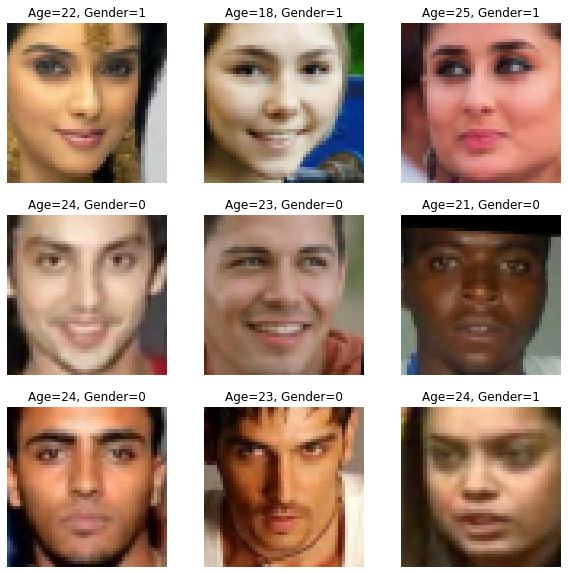

In [ ]:
img_size=(50,50)

images = []
age = []
gender = []
for img in os.listdir(path):
  ages = img.split("_")[0]
  
  if int(ages) <18 or int(ages)>25:
    continue
  
  genders = img.split("_")[1]
  img = cv2.imread(str(path)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, img_size, interpolation = cv2.INTER_AREA)
  images.append(np.array(img))
  age.append(np.array(ages))
  gender.append(np.array(genders))


### **Your Dataset**

In [ ]:
age = np.array(age,dtype=np.int64)
images = np.array(images) / 255.  
gender = np.array(gender,np.uint64)

n=9
idx_toplot = np.random.randint(len(images), size=n)
plt.figure(figsize=(10, 10))
for i in range(n):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[idx_toplot[i]])
  plt.title(f'Age={age[idx_toplot[i]]}, Gender={gender[idx_toplot[i]]}')
  plt.axis('off')

- Check for Classes Balance

In [ ]:
unique, counts = np.unique(gender, return_counts=True)
gender_class_counts = dict(zip(unique, counts))
print('Gender : ', gender_class_counts)

unique, counts = np.unique(age, return_counts=True)
print('Ages : ', dict(zip(unique, counts)))


Gender :  {0: 1162, 1: 2242}
Ages :  {18: 262, 19: 98, 20: 284, 21: 346, 22: 395, 23: 426, 24: 859, 25: 734}


### **Rebalancing Age Classes**


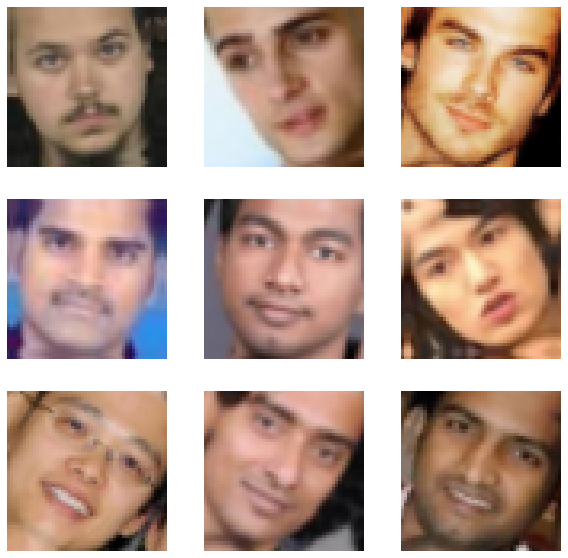

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_size[0],img_size[1],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Find the class to be augmented and the major one
minor_class = min(gender_class_counts, key=gender_class_counts.get)
major_class = max(gender_class_counts, key=gender_class_counts.get)

# Select the images belonging to the class to augment
img_seeds = images[gender==minor_class]

# Select random indexes for the images to augment
n_augment = gender_class_counts[major_class]-gender_class_counts[minor_class]
idx_to_aug = np.random.randint(img_seeds.shape[0], size=n_augment)

new_images = []
new_gender = []
plt.figure(figsize=(10, 10))
for i in range(n_augment):
  augmented_image = data_augmentation(img_seeds[idx_to_aug[i]])
  new_images.append(augmented_image)
  new_gender.append(minor_class)

  if i<9:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

In [ ]:
balanced_images = np.append(images, new_images, axis=0)
balanced_gender = np.append(gender, new_gender, axis=0)

unique, counts = np.unique(balanced_gender, return_counts=True)
gender_class_counts = dict(zip(unique, counts))
print('Gender : ', gender_class_counts)

Gender :  {0: 2242, 1: 2242}


In [ ]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42)

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(balanced_images, balanced_gender, random_state=42)

### **Build,Train and SAVE the Gender Model**

In [ ]:
gender_model = Sequential()

gender_model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_size[0],img_size[1],3)))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(64, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(128, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(128, activation='relu'))
gender_model.add(Dense(1, activation='sigmoid', name='gender'))

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_test_gender, y_test_gender), epochs=10)

###########################
gender_model.save(save_model_path+'gender_model.h5')
###########################


Epoch 1/10
106/106 [==============================] - 23s 206ms/step - loss: 0.5406 - accuracy: 0.7098 - val_loss: 0.3665 - val_accuracy: 0.8359
Epoch 2/10
106/106 [==============================] - 16s 154ms/step - loss: 0.3256 - accuracy: 0.8665 - val_loss: 0.2696 - val_accuracy: 0.9010
Epoch 3/10
106/106 [==============================] - 17s 157ms/step - loss: 0.2494 - accuracy: 0.9069 - val_loss: 0.2540 - val_accuracy: 0.9072
Epoch 4/10
106/106 [==============================] - 17s 165ms/step - loss: 0.2060 - accuracy: 0.9224 - val_loss: 0.2682 - val_accuracy: 0.8965
Epoch 5/10
106/106 [==============================] - 17s 163ms/step - loss: 0.1946 - accuracy: 0.9301 - val_loss: 0.2103 - val_accuracy: 0.9233
Epoch 6/10
106/106 [==============================] - 19s 179ms/step - loss: 0.1757 - accuracy: 0.9355 - val_loss: 0.1871 - val_accuracy: 0.9295
Epoch 7/10
106/106 [==============================] - 17s 164ms/step - loss: 0.1541 - accuracy: 0.9489 - val_loss: 0.1963 - val_ac

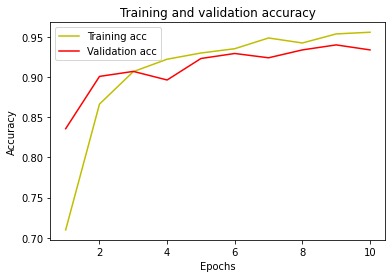

In [ ]:
history = history_gender
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



###**Build and Train the Age Model**

In [ ]:
age_model = Sequential()

age_model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_size[0],img_size[1],3)))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(64, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))
              
age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

# age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
# age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Flatten())
age_model.add(Dropout(0.2))
age_model.add(Dense(128, activation='relu'))

age_model.add(Dense(1, activation='linear', name='age'))
              
age_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(age_model.summary())              
                           
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_test_age, y_test_age), epochs=10)

#########################
age_model.save(save_model_path+'age_model.h5')
#########################

history = history_age
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### **LOAD a Pre-trained model**

Accuracy =  0.9322033898305084


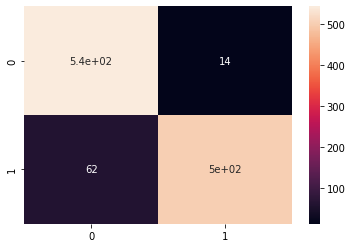

In [ ]:
from keras.models import load_model
#Test the model
gender_model = load_model('gender_model.h5', compile=False)


predictions = gender_model.predict(x_test_gender)
y_pred = (predictions>= 0.5).astype(int)[:,0]

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test_gender, y_pred))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test_gender, y_pred)  
sns.heatmap(cm, annot=True)

### **Feature Maps**

Activations 0:  (1, 48, 48, 32)
Activations 1:  (1, 23, 23, 32)
Activations 2:  (1, 21, 21, 64)
Activations 3:  (1, 10, 10, 64)
Activations 4:  (1, 8, 8, 128)
Activations 5:  (1, 3, 3, 128)
Activations 6:  (1, 1152)
Activations 7:  (1, 1152)
Activations 8:  (1, 128)
Activations 9:  (1, 1)




(-0.5, 47.5, 47.5, -0.5)

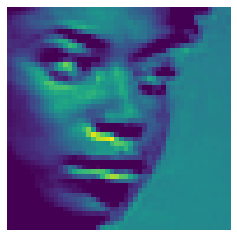

In [ ]:
# Extracts the outputs of the top conv layers
layer_outputs = [layer.output for layer in gender_model.layers] 

# Creates a model that will return these outputs, given the model input
activation_model = tf.keras.models.Model(inputs=gender_model.input, outputs=layer_outputs)

# Returns a list of Numpy arrays: one array per layer activation 
activations = activation_model.predict(np.reshape(x_test_gender[6], (-1,50,50,3))) 

for i,act in enumerate(activations):
  print(f'Activations {i}: ',act.shape)

print('\n')

#activations of layer 0
layer_activation = activations[0]


plt.matshow(layer_activation[0, :, :, 4], cmap='viridis')
plt.axis('off')

In [ ]:
layer_names = []
for layer in gender_model.layers:
  layer_names.append(layer.name)
  print(layer.name)


conv2d_6
max_pooling2d_6
conv2d_7
max_pooling2d_7
conv2d_8
max_pooling2d_8
flatten_2
dropout_2
dense_2
gender


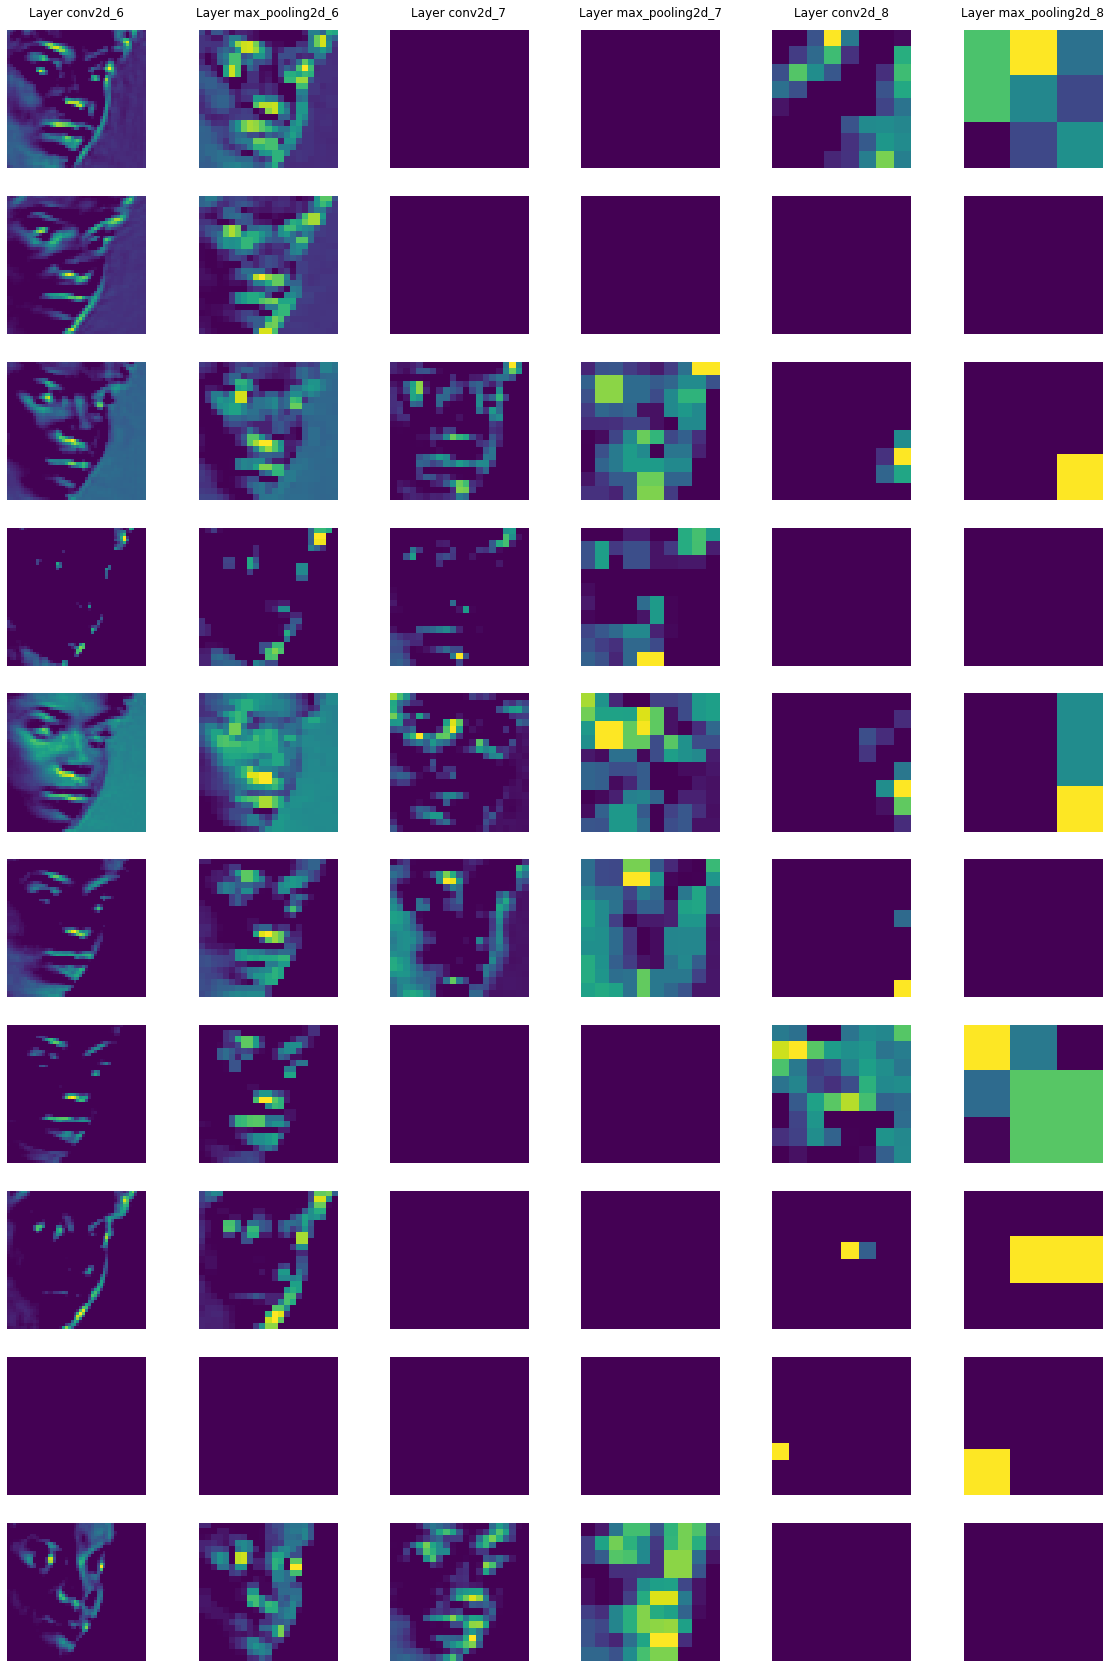

In [ ]:
# Feature map fo the first 6 layers
channels_to_show = 10
plt.figure(figsize=(20, 30))

n_layers = 6

col=0

for layer_name, layer_activation in zip(layer_names[:n_layers], activations[:n_layers]):
    col +=1
    for i in range(channels_to_show):
      ax = plt.subplot(channels_to_show, n_layers, i*n_layers+col)
      ax.matshow(layer_activation[0,:,:,i], cmap='viridis')
      if i==0:
        plt.title(f'Layer {layer_name}')
      ax.axis("off")

# **Transfer Learning**

- New Task: **Identify face Landmarks**
![An image](https://drive.google.com/uc?id=1rBkhcEtcwypiY26hVqVfvr_Q5TCj-0Iv)

- Dataset: Images + Landmarks

>1.   Load the Gender Model
2.   Adapt it to solve the new task
3.   Fine tune the weights of the adapted model









### **Landmark dataset**
TXT files where each line has the following structure:
> $filename \;  landmark_0 ... landmark_{68}$

where each $landmark$ is a couple $[x,y]$

- $[0:17]$ Around Chin (ear to ear)
- $[17:22]$ Left Eyebrow
- $[22:27]$ Right Eyebrow
- $[27:31]$ Top of Nose
- $[31:36]$ Bottom part of Nose
- $[36:42]$ Left Eye
- $[42:47]$ Left Eye
- $[47:68]$ Lips (outer and inside)




In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

landmarks_path = "/content/drive/MyDrive/COURSES/Deep Learning/MyLabs/UTKFaceDataset/Landmarks/"
faces_path = "/content/drive/MyDrive/COURSES/Deep Learning/MyLabs/UTKFaceDataset/UTKFace_Cropped/"
model_saved_path = "/content/drive/MyDrive/COURSES/Deep Learning/MyLabs/UTKFaceDataset/models/"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
new_img_size=(70,70)

images = []
landmarks = []
count=0
for land_file in os.listdir(landmarks_path)[1:2]:
  with open(landmarks_path+land_file) as f:
    line = f.readline()
    while line and len(images)<3000:
      line = f.readline()
      splitted = line.split(' ')
      
      age = splitted[0].split("_")[0]
  
      if int(age) <25 or int(age)>35 or age=='' :
        continue
      
      landmks = []
      for i in range(1,len(splitted)//2):
        landmks.append([float(splitted[i*2-1]),float(splitted[i*2])])

      img=None
      if splitted[0] != '':
        img = cv2.imread(faces_path+splitted[0]+'.chip.jpg')
      if img is None:
        continue
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, new_img_size, interpolation = cv2.INTER_AREA)
      images.append(np.array(img))
      
      points = np.array(landmks)
      points[:,0] //= (200/new_img_size[0])
      points[:,1] //= (200/new_img_size[1])
      landmarks.append(points.flatten())

In [ ]:
images = np.array(images)
n_images = images.shape[0]
landmarks = np.array(landmarks)

print(f'Images shape: {images.shape}')
print(f'Landmarks shape: {landmarks.shape}')

Images shape: (3000, 70, 70, 3)
Images shape: (3000, 136)


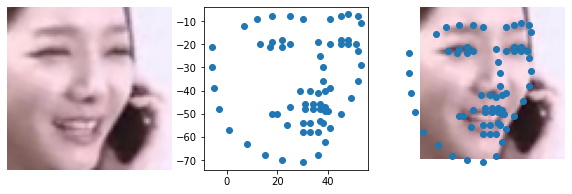

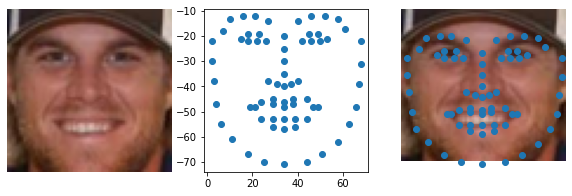

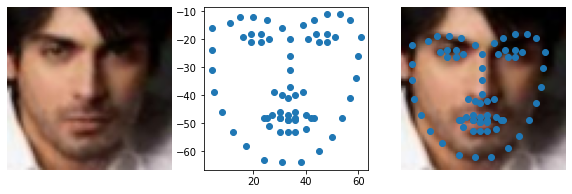

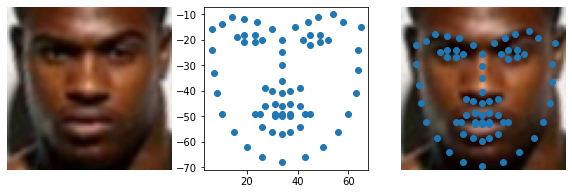

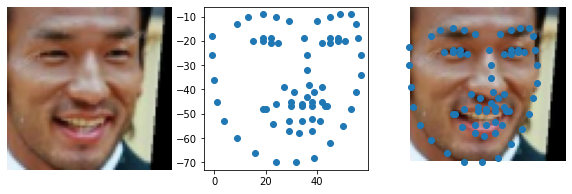

In [ ]:
for i in np.random.randint(n_images,size=5):
  plt.figure(figsize=(10,3))
  plt.subplot(1, 3, 1)
  plt.imshow(images[i],aspect='auto')
  plt.axis('off')
  
  points = np.reshape(landmarks[i], (-1,2))

  plt.subplot(1, 3, 2)
  plt.scatter(points[:,0],-points[:,1])
  plt.axis('on')
  
  plt.subplot(1, 3, 3)
  plt.imshow(images[i],aspect='auto')
  plt.scatter(points[:,0],points[:,1])
  plt.axis('off')


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, landmarks, test_size=0.2, random_state=42)

### **Load and Adapt the Gender Model**

       

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Input

#Test the model
source_model = load_model(model_saved_path+'gender_model.h5', compile=False)

print(source_model.summary())

print('\nDEEPER INTO THE PRETRAINED MODEL:\n')
for i,layer in enumerate(source_model.layers):
  print(f'{i} - {layer.name} - Input shape: {layer.input_shape} - Trainable: {layer.trainable}')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

> Both Model and Layer hold the attribute *trainable*. You can freeze the weights of the whole model or of a particular layer by setting *trainable=False* (dafault: True)

In [ ]:
new_model = Sequential()

#Add a new input layer
new_model.add(Input(shape=(new_img_size[0], new_img_size[1], 3)))
#Given the new dataset, you can change the input shape accordingly 
 .add(Resizing(50, 50))

#CHANGE THE NAME OF THE LAYER AND PAY ATTENTION TO THE PRETRAINED MODEL INPUT DIM
new_model.add(Conv2D(3, kernel_size=3, activation='relu', 
                name='conv2d_new'))

# go through until last layer
for layer in source_model.layers[:-3]:
  layer.trainable=False
  new_model.add(layer)

new_model.add(Dense(128, activation='relu'))
new_model.add(Dense(y_train.shape[1], activation='linear'))

new_model.compile(optimizer='adam', loss='mae')

print('\nDEEPER INTO THE NEW MODEL:\n')
for i,layer in enumerate(new_model.layers):
  print(f'{i} - {layer.name} - Trainable: {layer.trainable}')

### **Fine-Tunning**

Epoch 1/10
192/192 [==============================] - 15s 73ms/step - loss: 7.4898 - val_loss: 4.8868
Epoch 2/10
192/192 [==============================] - 19s 97ms/step - loss: 4.5074 - val_loss: 4.7371
Epoch 3/10
192/192 [==============================] - 18s 94ms/step - loss: 4.0864 - val_loss: 4.3341
Epoch 4/10
192/192 [==============================] - 14s 73ms/step - loss: 3.7845 - val_loss: 3.6593
Epoch 5/10
192/192 [==============================] - 15s 80ms/step - loss: 3.4549 - val_loss: 3.3558
Epoch 6/10
192/192 [==============================] - 16s 85ms/step - loss: 3.2883 - val_loss: 3.2284
Epoch 7/10
192/192 [==============================] - 14s 74ms/step - loss: 3.2042 - val_loss: 3.2598
Epoch 8/10
192/192 [==============================] - 13s 69ms/step - loss: 3.1376 - val_loss: 3.3346
Epoch 9/10
192/192 [==============================] - 18s 93ms/step - loss: 3.0915 - val_loss: 3.0866
Epoch 10/10
192/192 [==============================] - 18s 94ms/step - loss: 3.056

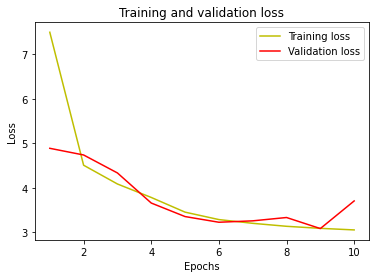

In [ ]:
history = new_model.fit(x_train,y_train, validation_split=0.2, batch_size=10, epochs=10)

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

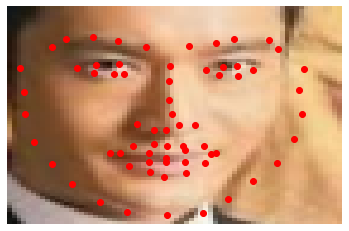

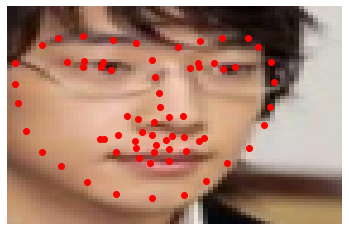

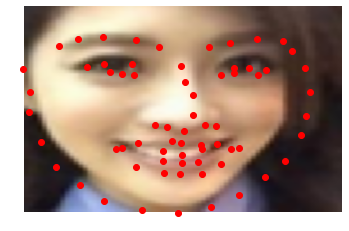

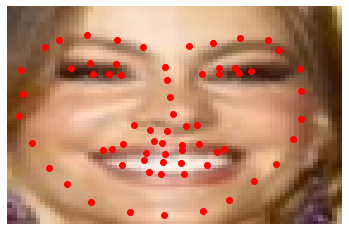

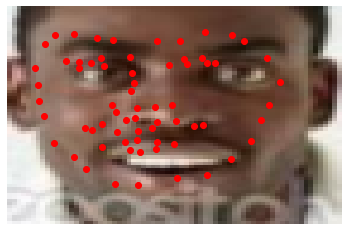

In [ ]:
for i in np.random.randint(x_test.shape[0],size=5):
  plt.figure()
  points = new_model(np.reshape(x_test[i],(-1,new_img_size[0],new_img_size[1],3)))
  points = np.reshape(points, (-1,2))
  plt.imshow(x_test[i],aspect='auto')
  plt.scatter(points[:,0],points[:,1],c='r')
  plt.axis('off')